# Hough Space line detection

This notebook presents implementation of Hough Space calculator alongside with helper function that returns **n most prominent lines** that have got most of the votes in accumulator.

Also there are some helper methods for edge detection, pixel restoration, etc.

Some inspiration was taken from open sources, rewritten and refactored.

In [1]:
import sys
import time

sys.path.insert(0, '../helpers/')

There are several Python scripts in the *../helpers/* folder. For instance *feature_detection_helper.py* containts a lot of useful functions for pre-processing the image before transforming Hough space.

You can get more sense and the documentation of the functions if you will open *feature_detection_helper.py*

Other useful script is *hough_transformer.py* which contains all the necessary functions for transforming image into hough space, creating the Hough Accumulator and etc.

You can get more sense and the documentation of the functions if you will open *hough_transformer.py*

In [2]:
# Helper Python script with usable pre-processing functions
from feature_detection_helper import * 

# Helper Python script with functions to transform image into Hough Space and visualize the intersections

from hough_transformer import * 

In [3]:
%matplotlib inline

## Load sample image

In [4]:
sample_image_name = 'marker_cut_rgb_512.png'

In [5]:
sample_image = load_data(sample_image_name)
sample_image_arr = np.array(sample_image)

## TL;DR One method to solve all your problems

If you don't want to go through the notebook and just get the indicies of n-most prominent lines please feel free to use the method below.

Applying Gaussian kernel of size 3 x 3...
Calculating gradients of the image...
Applying Double Threshold algorithm...
Applying Hysteresys algorithm
Calculating the Hough Space accumulator...


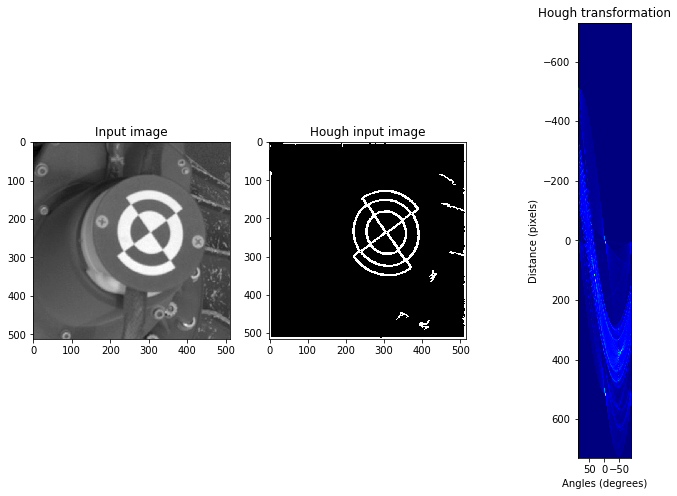

In [6]:
n_lines, accumulator = hough_space_n_lines(sample_image, 3, smooth = True)

In [7]:
for line in n_lines:
    print(line[0])

{'a': 6.123233995736766e-17, 'b': -1.0}
{'a': 1.0, 'b': 0.0}
{'a': 6.123233995736766e-17, 'b': -1.0}


In [8]:
cv2image = cv2.imread(sample_image_name, 0)

plot_lines(cv2image, n_lines)

## Hough space math background

A line in Cartesian form could be expressed in the equation:

*y = mx + b*

where: 

m = gradient or slope of the line (rise/run)   
b = y-intercept

![Example of two points with various intersections](hough_mb_parameter_space.png)

If we have two example points, for each point we can set different values of *m* and therefore obtain different intersections, and we can compute corresponding *b* values.

All points on a line in image space intersect at a common point in parameter space. This common point *(m, b)* represents the line in image space.
Unfortunately, the slope, *m*, is undefined when the line is vertical (division by 0!).
To overcome this, we use another parameter space, the hough space.

## Polar coordinate system

A line in Polar coordinate system could be expressed in the equation:

*ρ = x cos θ + y sin θ*

where:

*ρ (rho)* = distance from origin to the line. [-max_dist to max_dist].
          max_dist is the diagonal length of the image.  
*θ* = angle from origin to the line. [-90° to 90°]


## Algorithm steps

1. **Corner or edge detection**. We can use **Canny, Sobel or Adaptive Thresholding algorithm**. The result of this step is binary or grey image with zeros indicating non-edges and ones indicating edges. The result is now interpreted as our input image

2. **Rho range and Theta range creation.** ρ ranges from *-max_dist* to *+max_dist* where *max_dist* is the diagonal length of the input image (the number of diagonal entries in image matrix). θ ranges from *-90∘ to 90∘*. 

3. **Hough accumulator of θ vs ρ**. Is a 2D array with the number of rows equal to the number of ρ values and the number of columns equal to number of θ values.

4. **Accumulator voting**. For each of the edge points and for each of θ we find the nearest corresponding ρ value and increment it index in the accumulator. Each element in our accumulator matrix tells how many pixels contributed votes for line candidate with tuple of parameters (ρ, θ)

5. **Peak search**. Maximum values in the accumulator matrix indicate parameters of most probable lines in the image. Peaks could be found by applying some threshold.

## Convolution operator

Convolution is a simple mathematical operation which is fundamental to many common image processing operators. Convolution provides a way of multiplying together two arrays of numbers, generally of different sizes, but of the same dimensionality, to produce a third array of numbers of the same dimensionality. 

This can be used in image processing to implement operators whose output pixel values are simple linear combinations of certain input pixel values.

The implementation is based on cpython implementation and the main inspiration/logic flow was taken from there.

## Canny Edge Detector (CED)

*The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works (C)*

The general algorithm goes in five steps:

- Noise reduction
- Image gradient calculation
- Non-maximum suppression (*optional*)
- Double threshold (*optional*)
- Edge tracking


The algorithm is based on grayscale images, so the input image should be grayscale

### Noise reduction

Since this algorithm is based on gradient calculation it is very sensitive to image noise and the **noise reduction** stage is crucial.
The easiest approach is to add Gaussian blur to the image to smooth it. We need to select the kernel size of the Gaussian Filter, which will set the amount of blur.

![Gaussian Kernel formula](gaussian_kernel_formula.png)

### Gradient Calculation

Gradient calculation detects the edge intensity and direction by calculating the gradient of the whole image using edge detection operators.

*Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)*

After image smoothing phase the *Ix* and *Iy* are calculated. It could be implemented with Sobel Kernels *Kx* and *Ky*.

![Sobel Filters](sobel_filters.png)

![Magnitude](magnitude.png)

### Non-maximum suppression

This approach is used to have thin edges in our images. Non-thin edges could be encountered due to various reasons - one of them is blur. The princimple is quite simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with maximum value in the edge directions.

The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed.

The algorithm flow:

- Create zeros matrix of the same size as the original gradient matrix
- Identify the edge direction based on the angle value from the matrix of angles
- Check if the pixels in the same direction of the current processed pixel have higher intensity

### Double threshold

The main idea of double threshold is to identify three types of pixels: strong, weak and non-relevant. 

- **Strong pixels** - have very high intensity, compared to others, and will contributed to edge detection.
- **Weak pixels** - are something in mediocre of strong and non-relevant pixels. 
- **Non-relevant** - have very low intensity and therefore won't contribute to edge detection


So what is the idea of **double** threshold? We set two hyperparameters - **high threshold** and **low threshold**. 

- Pixels, that have intensity higher than high threshold are considered **strong**
- Pixels, that have intensity lower than low threshold are considered **non-relevant**
- All other pixels are considered **weak**

### Hysteresis edge tracking

The final improvement step called the **Hysteresis** is used to transform weak pixels into strong ones if there are at least one strong pixel near the current processed weak one.

![Hysteresis](hysteresis.png)

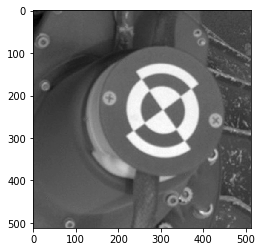

In [9]:
# Original image

imgplot = plt.imshow(sample_image_arr, cmap = 'gray')

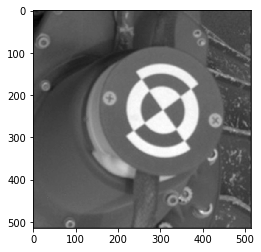

In [10]:
# Smooth the sample image

smoothed_image = convolve_kernel(sample_image_arr, gaussian_kernel(3))
imgplot = plt.imshow(smoothed_image, cmap = 'gray')

We see that the edges of our marker become more smooth and the edges of the the screws become smoother as well.

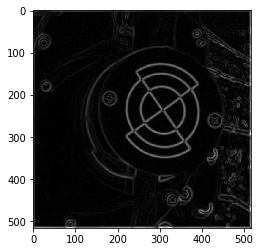

In [11]:
# Find the gradients and apply non-max suppression

grad_matrix, theta_matrix = sobel_filters(smoothed_image)
imgplot = plt.imshow(grad_matrix, cmap = 'gray')

Non-max suppression doesn't give us a lot of improvement so we therefore won't use it for this image, but it could be used for any other image and is implemented correctly.

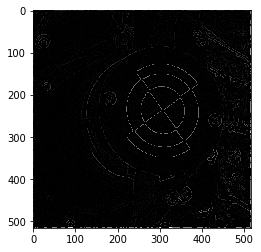

In [12]:
non_max_image = non_max_suppression(grad_matrix, theta_matrix)
imgplot = plt.imshow(non_max_image, cmap = 'gray')

After non-max suppression and Sobel gradients the image became very low-saturated.

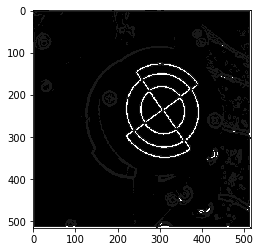

In [13]:
# Apply double thresholding

threshold_image, weak_pixels, strong_pixels = double_threshold(grad_matrix, 0.25, 0.35)

imgplot = plt.imshow(threshold_image, cmap = 'gray')

Double thresholding helped us to detect strong and weak pixels on the image.

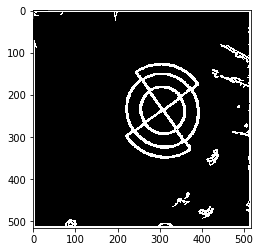

In [14]:
# Apply hysteresys search

hysteresys_img = hysteresis(threshold_image, weak_pixels, strong_pixels)

imgplot = plt.imshow(hysteresys_img, cmap = 'gray')

Hysteresis algorithm helped us to restore some of the necessary pixels and the lines of the image are now less intermittent.

We can see that image noise was decreased and the lines are visible much better now.

In [15]:
# Apply Hough space algorithm

accumulator, rhos, thetas = hough_lines_acc(hysteresys_img)

Now we will plot the Hough space. The brighter spots correspond to more prominent lines.

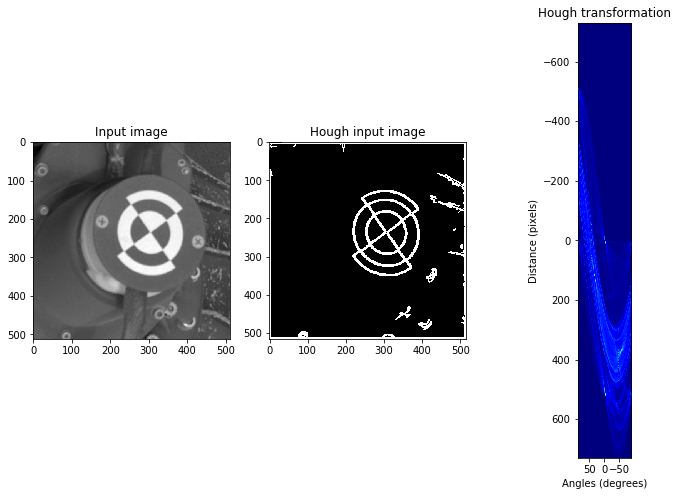

In [16]:
plot_hough_lines(sample_image, hysteresys_img, accumulator, rhos, thetas)

We can clearly see the intersection which are the prominent lines.

Main inspiration was taken from http://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm about the logic and visualization.

Two curves have a point of intersection — and this point describes the equation of the line in the image space. The 2 points independently can belong to a lot of possible lines (as they p and θ can vary). However, there is only one possible (p, θ) line, which goes through both of the points.

In [17]:
hough_acc_peaks = hough_peaks(accumulator, 3)
lines_list = hough_lines_transofrm(hough_acc_peaks, rhos, thetas, 3)

In [18]:
for line in lines_list:
    print(line[0])

{'a': 6.123233995736766e-17, 'b': -1.0}
{'a': 1.0, 'b': 0.0}
{'a': 6.123233995736766e-17, 'b': -1.0}


In [19]:
cv2image = cv2.imread(sample_image_name, 0)

plot_lines(cv2image, lines_list)